In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


## TensorFlow에서 수학을 하는것

TensorFlow는 Numpy를 사용하는것과 정확히 똑같은 방법으로 사용할 수 있습니다. 이 둘의 주요 다른점은 작성한 TensorFlow의 코드는 GPU와 TPU 상에서 실행될 수 있다는 점입니다:

In [ ]:
# a = tf.random.normal(shape=(2, 2))
# b = tf.random.normal(shape=(2, 2))

a = tf.constant([[5., 2], [1, 3]])
b = tf.Variable([[6., 7], [8, 9]])

c = a + b
d = tf.square(c)
e = tf.exp(d)

In [ ]:
a, b.numpy()

(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[5., 2.],
        [1., 3.]], dtype=float32)>, array([[6., 7.],
        [8., 9.]], dtype=float32))

In [ ]:
a = tf.square(a)
a

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[25.,  4.],
       [ 1.,  9.]], dtype=float32)>

In [ ]:
b = tf.exp(b)
b

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 403.4288, 1096.6332],
       [2980.958 , 8103.084 ]], dtype=float32)>

In [ ]:
f = tf.Variable([[6., 7], [8, 9]])
f

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[6., 7.],
       [8., 9.]], dtype=float32)>

In [ ]:
c = f + b
c

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 409.4288, 1103.6332],
       [2988.958 , 8112.084 ]], dtype=float32)>

In [ ]:
f = tf.square(f)
f

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[36., 49.],
       [64., 81.]], dtype=float32)>

## `GradientTape`을 사용해서 경사도를 계산하는것

한 가지 더 Numpy와의 큰 차이점이 있습니다: 모든 미분가능한 표현에 대해서, 자동으로 경사도를 구하는 것이 가능합니다.

단순히 [`GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape)를 열게되면, 그때부턴 `tape.watch()`를 통해 텐서를 확인하고, 이 텐서를 입력으로써 사용하는 미분가능한 표현을 구성하는것이 가능합니다:

In [ ]:
a = tf.Variable([[5., 2], [1, 3]])
b = tf.Variable([[6., 7], [8, 9]])
for i in range(2):
  with tf.GradientTape() as tape:
    # c = tf.sqrt(tf.square(a) + tf.square(b))
    c = a + b
    print(c)
    a = a * 0.01
    dc_da = tape.gradient(c, a)
    # dc_db = tape.gradient(c, b)
    print(dc_da)

tf.Tensor(
[[11.  9.]
 [ 9. 12.]], shape=(2, 2), dtype=float32)
None
tf.Tensor(
[[6.05 7.02]
 [8.01 9.03]], shape=(2, 2), dtype=float32)
None


GradientTape을 중첩시켜서 고차원의 미분을 계산할 수도 있습니다:

In [ ]:
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as tape:
    c = tf.sqrt(tf.square(a) + tf.square(b))
    dc_da = tape.gradient(c, a)
  d2c_da2 = outer_tape.gradient(dc_da, a)
  print(d2c_da2)

tf.Tensor(
[[0.07556275 0.12699373]
 [0.1221265  0.09486833]], shape=(2, 2), dtype=float32)


## end-to-end 예제: 선형 회귀

지금까지 TensorFlow는 Numpy와 비슷한 라이브러리인데, 추가적으로 GPU 또는 TPU를 통해 가속될 수 있고, 자동으로 미분이 계산된다는 내용을 배웠습니다. 그러면 이제는 end-to-end 예제를 알아볼 시간입니다: 머신러닝의 피즈버즈인, 선형 회귀를 구현해 봅시다. 

이를 보여주기 위해서, `Layer` 또는 `MeanSquaredError`와 같은 Keras의 고수준 컴포넌트를 사용하지 않을 것입니다. 단지 기본적인 연산자만을 사용합니다.

In [ ]:
import tensorflow as tf
import numpy as np

input_dim = 2
output_dim = 1
learning_rate = 0.01

# 가중치 행렬입니다
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# 편향 벡터입니다
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
  result = tf.matmul(features, w) + b
  print('compute_predictions :',w, b, result)
  return result

def compute_loss(labels, predictions):
  result = tf.reduce_mean(tf.square(labels - predictions))
  # print(w, b, result)
  return result

# @tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    print(y.shape, predictions.shape, loss.shape)
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  # print('train_on_batch : ', w, b)
  return loss

In [ ]:
w, b

(<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
 array([[0.7215904 ],
        [0.25812006]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)

In [ ]:
import seaborn as sns
iris = sns.load_dataset('iris')
iris

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [ ]:
df = iris[iris.species != 'setosa']
df.info(), df.species.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 50 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  100 non-null    float64
 1   sepal_width   100 non-null    float64
 2   petal_length  100 non-null    float64
 3   petal_width   100 non-null    float64
 4   species       100 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.7+ KB


(None, array(['versicolor', 'virginica'], dtype=object))

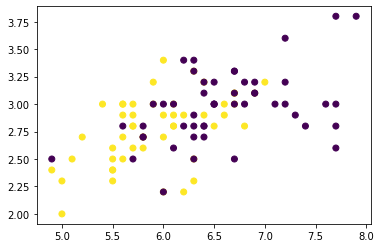

In [ ]:
features = df[['sepal_length', 'sepal_width']].values.astype(np.float32)
labels = df['species'].map({'versicolor': 1, 'virginica': 0}).values.astype(np.float32)
import matplotlib.pyplot as plt
plt.scatter(features[:, 0], features[:, 1], c=labels)

In [ ]:
type(features), len(features), features.dtype, labels

(numpy.ndarray,
 100,
 dtype('float32'),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
# 데이터를 무작위로 섞습니다
# random.Random(1337).shuffle(features)
# random.Random(1337).shuffle(labels)

# 손쉽게 배치화된 반복을 위해, tf.data.Dataset 객체를 생성합니다
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=100).batch(20)

In [ ]:
dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.float32, name=None))

In [ ]:
list(dataset.as_numpy_iterator())[:2]

[(array([[6.7, 3.3],
         [6.9, 3.2],
         [5.7, 3. ],
         [6.5, 3. ],
         [6.3, 3.4],
         [5.6, 3. ],
         [6.9, 3.1],
         [7.7, 2.8],
         [6.9, 3.1],
         [7.2, 3.6],
         [5.8, 2.7],
         [6.5, 3. ],
         [5.7, 2.5],
         [6.4, 3.2],
         [6.6, 2.9],
         [6.1, 2.8],
         [5.8, 2.7],
         [5.9, 3.2],
         [7.9, 3.8],
         [6.4, 2.7]], dtype=float32),
  array([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
         1., 0., 0.], dtype=float32)),
 (array([[6.1, 2.9],
         [6.9, 3.1],
         [6.4, 3.1],
         [5.8, 2.8],
         [6.7, 3.3],
         [7.1, 3. ],
         [6.5, 3. ],
         [6.1, 3. ],
         [6.3, 2.3],
         [6.7, 3. ],
         [6.1, 2.6],
         [6.4, 2.8],
         [5.7, 2.9],
         [5.6, 2.8],
         [6.4, 2.9],
         [6. , 3.4],
         [6.8, 3.2],
         [7.3, 2.9],
         [5.5, 2.4],
         [5.5, 2.6]], dtype=float32),
  array([1

In [ ]:
import time

t0 = time.time()
for epoch in range(1):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
t_end = time.time() - t0
print('Take Time Per epoch: %.3f sec' % (t_end / 20,))

# without @tf.function
# epoch당 걸린 시간: 0.005 초
# within @tf.function
# epoch당 걸린 시간: 0.004 초

compute_predictions : <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.10002482],
       [0.31919456]], dtype=float32)> <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)> tf.Tensor(
[[1.6596694]
 [1.7277747]
 [1.6796744]
 [1.5138986]
 [1.6339284]
 [1.4958057]
 [1.5739136]
 [1.7015915]
 [1.5677351]
 [1.7115939]
 [1.7215964]
 [1.5258131]
 [1.5577326]
 [1.4000473]
 [1.6639359]
 [1.5038962]
 [1.6077449]
 [1.6834984]
 [1.4977176]
 [1.7154179]], shape=(20, 1), dtype=float32)
(20,) (20, 1) ()
compute_predictions : <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.04500854],
       [ 0.2526036 ]], dtype=float32)> <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-0.02214298], dtype=float32)> tf.Tensor(
[[0.410595  ]
 [0.48361996]
 [0.493633  ]
 [0.3970924 ]
 [0.3988372 ]
 [0.3936029 ]
 [0.43861145]
 [0.33655867]
 [0.5576563 ]
 [0.42960972]
 [0.5631684 ]
 [0.26353368]
 [0.36007428]
 [0.3970924 ]
 [0.38

아래는 우리가 만든 모델이 얼마나 잘 동작하는지를 보여줍니다:

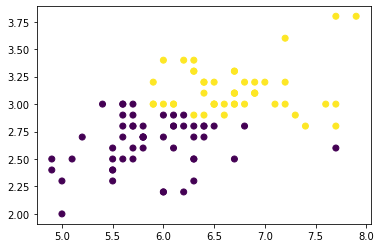

In [ ]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions > 0.5)

In [ ]:
# predictions.shape, predictions

# 파트 2: Keras API

Keras는 딥러닝을 위한 파이썬 API 입니다. 모두가 사용할만한 내용을 가지고 있습니다:

- 엔지니어의 경우, Keras는 계층, 평가지표(metrics), 학습 반복문과 같은 재사용 가능한 블록을 제공하여 일반적은 사용 사례를 지원합니다. 고수준의 사용자 경험을 제공하여 접근이 용이하고, 생산성이 좋습니다.

- 연구자의 경우, 계층이나 학습 반목문과 같은 이미 제공되는 블록의 사용을 선호하지 않고, 스스로 만든 것을 대신 사용할 지도 모릅니다. 물론, Keras는 이를 가능하게 해 줍니다. 이 경우, Keras는 여러분이 작성하게될 블록에 대한 템플릿을 Layers 및 Metrics와 같은 표준적인 API와 함께 제공합니다. 이러한 구조는 다른 사람과 코드를 쉽게 공유하고, 상용의 작업 흐름에도 통합될 수 있게끔 해 줍니다.

- 이 같은 내용은 라이브러리를 개발하는 분들에게도 적용되는 사실입니다. TensorFlow는 거대한 생태계죠. 수 많은 라이브러리가 존재합니다. 서로다른 라이브러리가 상호작용하고, 이들의 컴포넌트를 공유할 수 있게하기 위해선 API 표준을 따라야만 합니다. API 표준이 곧 Keras가 제공하는 핵심입니다.


Keras는 결정적으로 고수준의 UX와 저수준의 유연성을 모두 함께 완만히 도입합니다. 이는 더이상 한편으론 사용성이 뛰어나지만 유연치는 못한 고수준 API를, 다른 한편으론 매우 유연하지만 전문가만이 사용가능한 저수준 API를 가져야만 하는 상황에서 벗어나게 해 줍니다. 그 대신, 매우 고수준에서부터 매우 저수준 까지의 다양한 작업 흐름의 범위를 가질 수 있게 됩니다. 이 작업흐름이란, 동일한 컨셉과 객체에 기반해서 만들어졌기 때문에 모든것이 상호 호환 가능한 것을 의미합니다.

![Keras 작업 흐름의 범위](https://drive.google.com/uc?export=view&id=1bE0FiQY2XF5QzBLRHfe7-SdxvwGIO0GK)

## `Layer` 기본 클래스

가장 첫 번째로 알아야할 클래스는 [`Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) 입니다. Keras의 거의 모든것은 이 클래스로부터 파생됩니다.

Layer는 상태(가중치, weights)와 몇 (`call` 메소드에 정의된)계산을 캡슐화 합니다.

In [6]:
import tensorflow as tf

from tensorflow.keras.layers import Layer

class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32, input_dim=32):
      super(Linear, self).__init__()
      w_init = tf.random_normal_initializer()
      self.w = tf.Variable(
          initial_value=w_init(shape=(input_dim, units), dtype='float32'),
          trainable=True)
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(
          initial_value=b_init(shape=(units,), dtype='float32'),
          trainable=True)

  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

# 우리가 만든 Layer객체를 인스턴스화 합니다
linear_layer = Linear(4, 2)

In [ ]:
linear_layer.weights

[<tf.Variable 'Variable:0' shape=(2, 4) dtype=float32, numpy=
 array([[ 0.03777955,  0.00356271,  0.00621736, -0.07459953],
        [ 0.00310237, -0.02516671, -0.0785743 , -0.01842619]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

Layer 인스턴스는 마치 함수처럼 동작합니다. 몇 데이터에 대해서 이를 호출해 봅시다:

In [ ]:
y = linear_layer(tf.ones((2, 2)))
y.shape, y

(TensorShape([2, 4]), <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 0.04088192, -0.021604  , -0.07235694, -0.09302571],
        [ 0.04088192, -0.021604  , -0.07235694, -0.09302571]],
       dtype=float32)>)

`Layer` 클래스는 속성으로써 부여된 weights를 통해서, 가중치들을 추적합니다 

In [ ]:
# 가중치는 자동으로 `weights`라는 속성으로써 추적됩니다.
# linear_layer.weights == [linear_layer.w, linear_layer.b]
linear_layer.weights

[<tf.Variable 'Variable:0' shape=(2, 4) dtype=float32, numpy=
 array([[ 0.03777955,  0.00356271,  0.00621736, -0.07459953],
        [ 0.00310237, -0.02516671, -0.0785743 , -0.01842619]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

`add_weight`를 이용하여 간단히 가중치를 생성하는 방법이 있는것도 알아두세요. 이렇게 코드를 작성하는것 대신:

```python
w_init = tf.random_normal_initializer()
self.w = tf.Variable(initial_value=w_init(shape=shape, dtype='float32'))
```

일반적으로 아래와 같이 작성합니다:

```python
self.w = self.add_weight(shape=shape, initializer='random_normal')
```

`build`라는 별도의 메소드에서 가중치를 생성하는것이 좋은 관례입니다. 이 `build`는 Layer에 의해 첫 번째 입력의 Shape이 확인되는 순간 호출되는 lazy한 메소드 입니다. 이러한 패턴은 입력 차원(input_dim)을 생성자에 명시하지 않아도 되게 해 줍니다:

In [5]:
import tensorflow as tf

from tensorflow.keras.layers import Layer

class Linear(Layer):
  """y = w.x + b"""

  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units
      print('__init__')

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='zero',
                               trainable=False)
      print('build')
  def call(self, inputs):
      print('call')
      return tf.matmul(inputs, self.w) + self.b




In [6]:
# Lazy한 Layer의 인스턴스를 만듭니다.
linear_layer = Linear(2)

linear_layer.units

__init__


2

In [7]:
# 이렇게 하면, `build(input_shape)`이 호출되어 가중치를 생성하게 됩니다.
y = linear_layer(tf.ones((2, 2)))
# y = linear_layer(tf.zeros((5, 3)))

linear_layer.weights, linear_layer.get_weights(), y

build
call


([<tf.Variable 'linear/Variable:0' shape=(2, 2) dtype=float32, numpy=
  array([[-0.00238069, -0.0595932 ],
         [ 0.08768764,  0.041223  ]], dtype=float32)>,
  <tf.Variable 'linear/Variable:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>],
 [array([[-0.00238069, -0.0595932 ],
         [ 0.08768764,  0.041223  ]], dtype=float32),
  array([0., 0.], dtype=float32)],
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 0.08530695, -0.0183702 ],
        [ 0.08530695, -0.0183702 ]], dtype=float32)>)

## 학습 가능한, 그리고 학습 불가능한 가중치

Layer에 의해 생성된 가중치는 학습이 가능할 수도, 학습이 불가능할 수도 있습니다. 이 두 경우는 각각 
`trainable_weights` 및 `non_trainable_weights`로써 노출되어 외부에서 접근 가능합니다. 다음은 학습 불가능한 가중치를 가지는 Layer를 보여줍니다:

In [ ]:
class ComputeSum(Layer):
  """입력의 합산 결과를 반환하는 Layer"""

  def __init__(self, input_dim):
      super(ComputeSum, self).__init__()
      # 학습 불가능한 가중치를 생성합니다.
      self.total = tf.Variable(initial_value=tf.zeros((input_dim,)),
                               trainable=False)

  def call(self, inputs):
      self.total.assign_add(tf.reduce_sum(inputs, axis=0))
      return self.total  

my_sum = ComputeSum(2)
x = tf.ones((2, 2))

y = my_sum(x)
print(y.numpy())  # [2. 2.]

y = my_sum(x)
print(y.numpy())  # [4. 4.]

assert my_sum.weights == [my_sum.total]
assert my_sum.non_trainable_weights == [my_sum.total]
assert my_sum.trainable_weights == []

[2. 2.]
[4. 4.]


## 재귀적으로 Layer를 조합하는것

Layer들은 더 큰 계산을 위한 블록을 생성하기 위해 재귀적으로 중첩될 수 있습니다. 각각의 Layer는 각각의 (학습 가능한것과 학습 불가능한)가중치를 추적할 수 있습니다.

In [ ]:
# `build` 메소드와 함께 앞서 정의된
# Linear 클래스를 재사용 해봅시다

class MLP(Layer):
    """Linear Layer의 간단한 층을 쌓는 Layer 입니다."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)

mlp = MLP()

# `mlp` 객체에 대한 첫 번째 호출은 가중치를 생성하게 됩니다.
y = mlp(tf.ones(shape=(3, 64)))

# 가중치들은 재귀적으로 추적됩니다.
assert len(mlp.weights) == 6

## 미리 정의된 Layer의 종류

Keras는 [넓은 범위의 미리 정의된 Layer의 종류](https://www.tensorflow.org/api_docs/python/tf/keras/layers/)를 제공하여 항상 여러분 스스로가 모든것을 구현하지 않아도 되도록끔 해 줍니다.

- Convolution layers
- Transposed convolutions
- Separateable convolutions
- Average and max pooling
- Global average and max pooling
- LSTM, GRU (with built-in cuDNN acceleration)
- BatchNormalization
- Dropout
- Attention
- ConvLSTM2D
- etc.




Keras는 디폴트로 좋은 설정값을 노출시키는 원칙을 따릅니다. 이렇게 해서, 필요한 인자값을 디폴트값으로 내버려두어도 대부분의 경우에서 잘 동작할 수 있게끔 해 줍니다. 예를 들어서, `LSTM` Layer는 디폴트로 직교 순환 행렬 초기화자(orthogonal recurrent matrix intializer)를 사용하고, 이는 forget 게이트의 편향값을 1로써 초기화 합니다.

## `call` 메소드의 `training` 인자


몇 Layer, 특히 `BatchNormalization`과 `Dropout` Layer,는 학습과 추론단계에서 서로다른 동작방식을 가집니다. 이러한 종류의 Layer에 대해선, `call` 메소으의 (부울 형식인)`training` 인자를 노출시키는 것이 표준적인 관례입니다.

`call` 메소드의 이 인자를 노출시킴으로써, 미리 제공되는 학습과 평가 반복문(예를 들어서 `fit` 메소드)이 해당 Layer를 학습과 추론에 대해서 옳바르게 사용할 수 있게 됩니다.

In [ ]:
class Dropout(Layer):
  
  def __init__(self, rate):
    super(Dropout, self).__init__()
    self.rate = rate

  def call(self, inputs, training=None):
    if training:
      return tf.nn.dropout(inputs, rate=self.rate)
    return inputs

class MLPWithDropout(Layer):

  def __init__(self):
      super(MLPWithDropout, self).__init__()
      self.linear_1 = Linear(32)
      self.dropout = Dropout(0.5)
      self.linear_3 = Linear(10)

  def call(self, inputs, training=None):
      x = self.linear_1(inputs)
      x = tf.nn.relu(x)
      x = self.dropout(x, training=training)
      return self.linear_3(x)
    
mlp = MLPWithDropout()
y_train = mlp(tf.ones((2, 2)), training=True)
y_test = mlp(tf.ones((2, 2)), training=False)

## 좀 더 함수형적으로 모델을 정의하기 위한 방법

딥 러닝 모델을 만들기 위해서, 항상 객체지향적 프로그래밍 방법을 사용할 필요는 없습니다. 아래의 예시처럼 Layer들은 함수형적으로도 조합이 가능합니다 ("함수형 API" 라고 부릅니다):

In [ ]:
# `Input` 객체를 사용해서, 입력의 shape(모양)과 dtype(데이터형)을 묘사합니다.
# 딥러닝에서 이는 데이터형을 선언하는 방식입니다.
# shape 인자는 샘플당 으로, 배치 크기를 포함하지 않습니다. 
# 함수형 API는 샘플당 변형을 정의하는데 집중합니다.
# 생성하는 모델은 자동으로 샘플당 변형에 대한 배치를 고려합니다.
# 따라서, 모델은 데이터의 배치마다 호출됩니다.
inputs = tf.keras.Input(shape=(16,))

# 이러한 "데이터형"의 객체에 대해서 Layer를 호출하고,
# 호출 결과로 갱신된 (새로운 shape과 dtype을 가지는)"데이터형"을 반환합니다.
x = Linear(32)(inputs) # 앞서 정의된 Linear Layer를 재사용 합니다.
x = Dropout(0.5)(x)    # 앞서 정의된 Droptout Layer를 재사용 합니다.
outputs = Linear(10)(x)

# 함수형 `모델(Model)`은 입력과 출력을 명시하여 정의될 수 있습니다.
# 모델은 다른것과 마찬가지로 스스로가 또 하나의 Layer가 됩니다.
model = tf.keras.Model(inputs, outputs)

# 함수형 모델은 호출되기전, 이미 가중치를 가집니다.
# 그 이유는 입력에 대한 shape을 `input`에서 사전에 정의했기 때문입니다.
assert len(model.weights) == 4

# 똑같은 데이터에 대해서, 모델을 다시 호출해 봅시다.
y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

함수형 API는 하위 클래스를 만드는것 보다 더 간결하고, 여기엔 몇몇 부가적인 이점(일반적으로 함수형, 형 선언적 언어가 형 선언적이지 않은 객체지향 개발에 비해 가지는 이점과 동일)이 존재합니다. 하지만, 이는 Layer들의 DAGs를 정의하는데에만 사용될 수 있습니다. 재귀적인 네트워크는 `Layer`의 하위 클래스를 통해서 정의되어야 합니다.

함수형 모델과 하위 클래스를 통해 정의된 모델의 주요 다른점은 [이곳](https://medium.com/tensorflow/what-are-symbolic-and-imperative-apis-in-tensorflow-2-0-dfccecb01021)에 설명되어 있습니다.

[이곳](https://www.tensorflow.org/alpha/guide/keras/functional)을 방문해서, 함수형 API에 대해 좀 더 배워볼 수 있습니다.

연구의 작업 흐름에서, 객체지향 모델과 함수형 모델을 섞어쓰는 자신을 종종 발견하게 될지도 모릅니다.

단일 입력과 출력을 가지는 Layer을 이용해서, 여러 층으로 구성된 모델에 대하여 `Sequential` 클래스를 사용할 수도 있습니다. 이 클래스는 Layer의 목록을 `Model`로 변환해 줍니다:

In [2]:
from tensorflow.keras import Sequential

model = Sequential([Linear(32), Dropout(0.5), Linear(10)])

y = model(tf.ones((2, 16)))
assert y.shape == (2, 10)

NameError: ignored


## Loss 클래스

Keras는 넓은 범위의 미리 정의된 손실함수에 대한 Loss 클래스를 제공합니다. 이는 `BinaryCrossentropy`, `CategoricalCrossentropy`, `KLDivergence`등과 같은 것이 포함되며 다음과 같이 작동합니다:

In [11]:
import numpy as np

y_true02 = [0., 0., 1., 0.]  # 75%

y = np.array(y_true02)
np.mean(np.sqrt(y))

0.25

In [3]:
y_true01 = [0., 0., 1., 1.]  # 25%
y_true02 = [1., 0., 1., 0.]  # 75%
y_true03 = [1., 1., 1., 0.]  # 100%
y_pred = [1., 1., 1., 0.]  # 예측 결과
msle = tf.keras.losses.MeanSquaredLogarithmicError()
msle(y_true01, y_pred).numpy(), msle(y_true02, y_pred).numpy(), msle(y_true03, y_pred).numpy()

NameError: ignored

Loss 클래스는 상태를 가지지 않습니다. 즉, `__call__`의 출력은 입력에 대한 함수일 뿐입니다.

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse(y_true01, y_pred).numpy(), mse(y_true02, y_pred).numpy(), mse(y_true03, y_pred).numpy()

(0.75, 0.25, 0.0)

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true01, y_pred).numpy(), bce(y_true02, y_pred).numpy(), bce(y_true03, y_pred).numpy()

(11.522857, 3.8333097, -0.0)

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true01, y_pred).numpy(), bce(y_true02, y_pred).numpy(), bce(y_true03, y_pred).numpy()

(0.9082331, 0.6582331, 0.40823308)

In [ ]:
y_true01 = [[0, 0, 1], [1, 0, 0]] 
y_true02 = [[0, 1, 0], [0, 0, 1]] 
y_true03 = [[0, 1, 0], [0, 1, 0]] 
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
loss = tf.keras.losses.CategoricalCrossentropy()
loss(y_true01, y_pred).numpy(), loss(y_true02, y_pred).numpy(), loss(y_true03, y_pred).numpy()

(9.2103405, 1.1769392, 0.13721842)

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss(y_true01, y_pred).numpy(), loss(y_true02, y_pred).numpy(), loss(y_true03, y_pred).numpy()

(1.4618951, 0.9868951, 0.63689506)

In [ ]:
y_true01 = [2, 2, 0, 0]
y_true02 = [1, 2, 2, 1]
y_true03 = [1, 1, 2, 2]
y_pred01 = [[0.05, 0.95, 0], [0.1, 0.8, 0.1], [0.0, 0.1, 0.9], [0.0, 0.1, 0.9]]
y_pred02 = [[0., 1., 0.], [0., 1., 0.], [0., 0., 1.], [0., 0., 1.]]
loss = tf.keras.losses.SparseCategoricalCrossentropy()
loss(y_true01, y_pred01).numpy(), loss(y_true02, y_pred01).numpy(), loss(y_true03, y_pred01).numpy()

(12.664219, 1.190456, 0.12128952)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss(y_true01, y_pred01).numpy(), loss(y_true02, y_pred01).numpy(), loss(y_true03, y_pred01).numpy()

(1.4901321, 1.002632, 0.627632)

## Metric 클래스

또한, Keras는 넓은 범위의 미리 정의된 평가지표 함수에 대한 Metric 클래스를 제공합니다. 이는 `BinaryAccuracy`, `AUC`, `FalsePositives`등과 같은것을 포함합니다.

Loss와는 다르게, Metric은 상태를 가집니다. `update_state` 메소드를 사용해서 상태를 갱신하고, `result`를 사용해서 스칼라형태의 결과값을 요청할 수 있습니다:

In [ ]:
m = tf.keras.metrics.AUC()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('중간 결과: ', m.result().numpy())

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('최종 결과: ', m.result().numpy())

중간 결과:  0.6666667
최종 결과:  0.71428573


내부 상태는 `metric.reset_states`에 의해 초기화될 수 있습니다.

`Metric` 클래스의 하위 클래스를 만들어서, 여러분만의 평가지표 함수를 손쉽게 만들수도 있습니다:

- `__init__`내의 상태 변수를 생성합니다
- `update_state`내에서 인자로써 주어진 `y_true`와 `y_pred`를 이용해서 변수를 갱신합니다
- `result`내에서 평가지표의 결과를 반환합니다
- `reset_states`내에서 상태를 초기화 합니다

다음은 이 방법을 보여주기 위한 목적으로, `BinaryTruePositive` 평가지표에 대한 구현하고 있습니다:

In [ ]:
class BinaryTruePositives(tf.keras.metrics.Metric):

  def __init__(self, name='binary_true_positives', **kwargs):
    super(BinaryTruePositives, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    values = tf.cast(values, self.dtype)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      sample_weight = tf.broadcast_weights(sample_weight, values)
      values = tf.multiply(values, sample_weight)
    self.true_positives.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.true_positives

  def reset_states(self):
    self.true_positive.assign(0)

## Optimizer 클래스 & 빠른 end-to-end 학습 반복문

앞서 보여진 선형회귀 예제에서 작성한, 경사하강시 변수값을 직접 갱신하는 방법은 일반적으로 하지 않아도 됩니다. 보통은 `SGD`, `RMSprop`, 또는 `Adam`등과 같이 Keras에서 미리 제공되는 Optimizer 중 하나를 사용하면 됩니다.

아래는 MNIST 데이터에 대해서, Loss, Metric 클래스와 Optimizer가 모두 함께 사용되는 예를 보여줍니다.

In [ ]:
data01 = np.array([[0, 1],[2, 2],[1, 0],[1, 0],[2, 1]])
data02 = np.array([[0, 1],[2, 3],[4, 5],[6, 7],[8, 9]])
data03 = np.array([[0, 1000],[2, 3000],[4, 5000],[6, 7000],[8, 9000]])
data04 = np.array([[-0.00014, 100000],[-0.2400222, 30],[-0.00008, 50000000],[-0.4829, 70],[8, 0.9]])
labels01 = np.array([0, 1, 2, 3, 4])
labels02 = np.array([40000, 1000, 2800000, 39, 40])
labels03 = np.array([0, 1, 1, 0, 1])

## Data Scaling per Column

In [ ]:
data05 = data04.copy()
data05[:,0] = data04[:,0] / data04[:,0].max()
data05[:,1] = data04[:,1] / data04[:,1].max()
data05, data04[:,0].max(), data04[:,1].max()

(array([[-1.7500000e-05,  2.0000000e-03],
        [-3.0002775e-02,  6.0000000e-07],
        [-1.0000000e-05,  1.0000000e+00],
        [-6.0362500e-02,  1.4000000e-06],
        [ 1.0000000e+00,  1.8000000e-08]]), 8.0, 50000000.0)

##Data Scaling Max Values

In [ ]:
data06 = data04.copy()
data06 = data04 / data04.max()
data06, data04.max()

(array([[-2.800000e-12,  2.000000e-03],
        [-4.800444e-09,  6.000000e-07],
        [-1.600000e-12,  1.000000e+00],
        [-9.658000e-09,  1.400000e-06],
        [ 1.600000e-07,  1.800000e-08]]), 50000000.0)

In [ ]:
opt = ()
m = ()
data = data05
data = data / data.max()  # scale

labels=labels01
# labels = labels / labels.max()  # scale
# labels = np.log10(labels)  # scale

for i in range(3):
  opt = tf.keras.optimizers.RMSprop()
  # opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
  # opt = tf.keras.optimizers.Adam()
  # opt = tf.keras.optimizers.Nadam()
  # opt = tf.keras.optimizers.Nadam(beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  m = tf.keras.models.Sequential([tf.keras.layers.Dense(units=50)])  # Try add dropout(0.3)
  m.compile(opt, loss='mse');
  # m.compile(opt, loss=tf.keras.losses.MeanSquaredLogarithmicError());
  # m.compile(opt, loss=tf.keras.losses.MeanSquaredLogarithmicError(reduction=tf.keras.losses.Reduction.SUM));
  # m.compile(opt, loss='binary_crossentropy');   
  results = m.fit(data, labels, batch_size=1, verbose=2)
  # print(opt.get_weights())    #opt.weights
  opt.set_weights(opt.get_weights())   #opt.get_weights()
  opt.iterations

m.reset_states()
# m.reset_metrics()
# opt = ()

5/5 - 1s - loss: 0.3747
5/5 - 1s - loss: 0.3747
5/5 - 1s - loss: 0.3747


In [ ]:
# optimizers.RMSprop(), loss='mse'
# 5/5 - 0s - loss: 1.1397
# [<tf.Variable 'RMSprop/iter:0' shape=() dtype=int64, numpy=5>, <tf.Variable 'RMSprop/sequential_11/dense_24/kernel/rms:0' shape=(2, 1) dtype=float32, numpy=
# array([[0.09027224],
#        [1.969766  ]], dtype=float32)>, <tf.Variable 'RMSprop/sequential_11/dense_24/bias/rms:0' shape=(1,) dtype=float32, numpy=array([2.0604513], dtype=float32)>]
# 5/5 - 0s - loss: 1.1803
# [<tf.Variable 'RMSprop/iter:0' shape=() dtype=int64, numpy=5>, <tf.Variable 'RMSprop/sequential_12/dense_25/kernel/rms:0' shape=(2, 1) dtype=float32, numpy=
# array([[0.2868856],
#        [1.9651258]], dtype=float32)>, <tf.Variable 'RMSprop/sequential_12/dense_25/bias/rms:0' shape=(1,) dtype=float32, numpy=array([2.2536077], dtype=float32)>]
# 5/5 - 0s - loss: 0.9667
# [<tf.Variable 'RMSprop/iter:0' shape=() dtype=int64, numpy=5>, <tf.Variable 'RMSprop/sequential_13/dense_26/kernel/rms:0' shape=(2, 1) dtype=float32, numpy=
# array([[0.17692871],
#        [1.108282  ]], dtype=float32)>, <tf.Variable 'RMSprop/sequential_13/dense_26/bias/rms:0' shape=(1,) dtype=float32, numpy=array([1.2864558], dtype=float32)>]

In [ ]:
from tensorflow.keras import layers

# 데이터셋를 준비합니다
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[:].reshape(60000, 784).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# 간단한 분류를 위한 모델의 인스턴스를 만듭니다
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# 정수형 레이블을 인자로 받아들이는, 로지스틱 Loss의 인스턴스를 만듭니다
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 정확도에 대한 Metric의 인스턴스를 만듭니다
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Optimizer의 인스턴스를 만듭니다
optimizer = tf.keras.optimizers.Adam()

# 데이터셋의 데이터 배치를 순회합니다
for step, (x, y) in enumerate(dataset):
  
  # GradientTape 열어줍니다
  with tf.GradientTape() as tape:

    # 순방향 전파(forward)를 수행합니다
    logits = model(x)

    # 현재 배치에 대한 손실값을 측정합니다
    loss_value = loss(y, logits)
     
  # 손실에 대한 가중치의 경사도를 계산합니다
  gradients = tape.gradient(loss_value, model.trainable_weights)
  
  # 모델의 가중치를 갱신합니다
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  # 현재까지 수행된 전체에 대한 모델의 정확도를 갱신합니다
  accuracy.update_state(y, logits)
  
  # 로그를 출력합니다
  if step % 100 == 0:
    print('단계(Step):', step)
    print('마지막 단계(Step)의 손실:', float(loss_value))
    print('지금까지 수행된 전체에 대한 정확도:', float(accuracy.result()))

`SparseCategoricalAccuracy` Metric 인스턴스를 재사용해서 테스트 반복문을 구현할 수 있습니다:

In [ ]:
x_test = x_test[:].reshape(10000, 784).astype('float32') / 255
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)

accuracy.reset_states()  # 이 코드는 Metric의 내부 상태를 초기화 합니다

for step, (x, y) in enumerate(test_dataset):
  logits = model(x)
  accuracy.update_state(y, logits)

print('최종 테스트 정확도:', float(accuracy.result()))

## `add_loss` 메소드

때로는 순방향 전파(forward) 수행 중 손실값을 계산해 보고 싶을 수 있습니다 (특히, 정규화(regularization) 손실에 대해서). Keras는 어느시점에서든지 손실값을 계산할 수 있게 해 주고, `add_loss` 메소드를 통해 이 손실값을 재귀적으로 계속 추적할 수 있게 해 줍니다.

다음은 입력에 대한 L2 노름에 기반한 희소 정규화(regularization) 손실을 추가하는 Layer의 예를 보여줍니다:

In [ ]:
class ActivityRegularization(Layer):
  """활성 희소 정규화 손실(activity sparsity regularization loss)을 생성하는 Layer 입니다"""
  
  def __init__(self, rate=1e-2):
    super(ActivityRegularization, self).__init__()
    self.rate = rate
  
  def call(self, inputs):
    # 입력값에 기반하는
    # `add_loss`를 사용해서 정규화 손실을 생성합니다
    self.add_loss(self.rate * tf.reduce_sum(tf.square(inputs)))
    return inputs

`add_loss`를 이용해서 추가된 손실값은 `Layer` 또는 `Model`의 리스트형 속성인 `.losses`를 통해서 접근이 가능합니다:

In [ ]:
from tensorflow.keras import layers

class SparseMLP(Layer):
  """희소 정규화 손실을 가지는 선형 계층을 쌓아올린 Layer 입니다"""

  def __init__(self, output_dim):
      super(SparseMLP, self).__init__()
      self.dense_1 = layers.Dense(32, activation=tf.nn.relu)
      self.regularization = ActivityRegularization(1e-2)
      self.dense_2 = layers.Dense(output_dim)

  def call(self, inputs):
      x = self.dense_1(inputs)
      x = self.regularization(x)
      return self.dense_2(x)
    

mlp = SparseMLP(1)
y = mlp(tf.ones((10, 10)))

print(mlp.losses)  # float32 자료형의 단일 스칼라값을 가지는 리스트 입니다

이 손실값들은 순방향 전파(forward)의 시작점에 있는 최상위 Layer로부터 초기화되며 축적되지 않습니다. 따라서 `layer.losses`는 항상 마지막 순방향 전파동안 생성된 손실값만을 가지게 됩니다. 학습 반복문을 작성할 때, 일반적으로 경사도 계산 이전에 이 손실값들에 대한 합산을 수행합니다.

In [ ]:
# *마지막* 순방향 전파에 해당하는 손실값들 입니다
mlp = SparseMLP(1)
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 1
mlp(tf.ones((10, 10)))
assert len(mlp.losses) == 1  # 축적되지 않습니다

# 이 손실값들을 학습 반복문에서 사용하는법을 보여줍니다

# 데이터셋을 준비합니다
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype('float32') / 255, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# 새로운 MLP를 만듭니다
mlp = SparseMLP(10)

# Loss와 Optimizer를 만듭니다
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for step, (x, y) in enumerate(dataset):
  with tf.GradientTape() as tape:

    # 순방향 전파를 수행합니다
    logits = mlp(x)

    # 현재 배치에 대한 외부의 손실값을 계산합니다
    loss = loss_fn(y, logits)
    
    # 순방향 전파시 생성된 손실값을 더해줍니다 
    loss += sum(mlp.losses)
     
    # 해당 손실에 대한 가중치의 경사도를 계산합니다
    gradients = tape.gradient(loss, mlp.trainable_weights)
  
  # 모델의 가중치를 갱신합니다
  optimizer.apply_gradients(zip(gradients, mlp.trainable_weights))
  
  # 로그를 출력합니다
  if step % 100 == 0:
    print(step, float(loss))

## 자세한 end-to-end 예제: Variational AutoEncoder (VAE)

기초적인 내용의 공부를 잠시 미뤄두고, 약간 더 어려운 예제를 살펴보고 싶다면, [여기에 소개된 VAE](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)에 대한 구현의 예제를 확인해 보시기 바랍니다. 이는 여러분이 지금까지 배워왔던 모든것의 내용을 담고 있습니다:

- `Layer`의 하위 클래스를 만드는것
- 재귀적으로 Layer를 구성하는것
- Loss 및 Metric 클래스에 대한것
- `add_loss`
- `GradientTape`

## 미리 정의된 학습 반복문을 사용하는것

간단한 케이스에 대해서 조차 여러분이 스스로 저수준의 학습 반복문을 매번 작성해야 한다면, 이는 어리석은 일일지도 모릅니다. Keras는 미리 정의된 학습 반복문을 `Model` 클래스에서 제공합니다. 사용하고자 한다면, `Model`의 하위 클래스를 만들거나 `Functional(함수형)` 또는 `Sequential(순차형)` 모델을 생성하면 됩니다.

이를 보여주기 위해서, 앞서 만들어둔 MNIST의 예를 재사용 해 보겠습니다:

In [ ]:
# 데이터셋을 준비합니다
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

# 간단한 분류모델의 인스턴스를 만듭니다
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# 정수형 레이블을 인자로 받아들이는, 로지스틱 Loss의 인스턴스를 만듭니다
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 정확도에 대한 Metric의 인스턴스를 만듭니다
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Optimizer의 인스턴스를 만듭니다
optimizer = tf.keras.optimizers.Adam()

가장 첫 번째로, `compile` 메소드를 호출하여 Optimizer, Loss, 모니터링하기 위한 Metric을 설정합니다.

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

그리고 나선 `fit` 메소드를 호출하고, 이 때 데이터를 전달해 줍니다:

In [ ]:
model.fit(dataset, epochs=3)

이게 끝입니다! 이제는 테스트를 해 봅시다:

In [ ]:
x_test = x_test[:].reshape(10000, 784).astype('float32') / 255
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)

loss, acc = model.evaluate(test_dataset)
print('손실:', loss, '정확도:', acc)

`fit`이 수행되는 동안 검증용 데이터셋에 대한 Loss와 Metric을 모니터링 하는것 또한 가능합니다.

또한, Numpy형의 배열에 대해서도 직접적으로 `fit`을 호출할 수 있습니다. 따라서 데이터셋에 대한 변환이 필요 없습니다:

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

num_val_samples = 10000
x_val = x_train[-num_val_samples:]
y_val = y_train[-num_val_samples:]
x_train = x_train[:-num_val_samples]
y_train = y_train[:-num_val_samples]

# 간단한 분류모델의 인스턴스를 만듭니다
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# 정수형 레이블을 인자로 받아들이는, 로지스틱 Loss의 인스턴스를 만듭니다
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 정확도에 대한 Metric의 인스턴스를 만듭니다
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Optimizer의 인스턴스를 만듭니다
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[accuracy])
model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          epochs=3,
          batch_size=64)

## Callbacks

`fit`이 가지는 간단하지만 훌륭한 기능 중 하나로, [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/)을 사용해서 학습과 평가 도중 일어나는 일에 대한 사용자 정의화가 가능합니다.

Callback은 객체의 한 종류로, 학습 중간 중간에 호출(예를들어, 매 배치마다 또는 매 epoch마다) 되며 어떤 작업을 수행합니다.

미리 정의된 여러가지 Callback이 존재합니다. `ModelCheckpoint`는 학습도중 매 epoch마다 모델을 저장하고, `EarlyStopping`은 검증용 평가지표(metrics)가 향상되지 않을 때 학습을 중단시킵니다.

물론, 손쉽게 [여러분만의 callback을 작성할 수도 있습니다](https://www.tensorflow.org/guide/keras/custom_callback).


In [ ]:
# 간단한 분류모델의 인스턴스를 만듭니다
model = tf.keras.Sequential([
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(256, activation=tf.nn.relu),
  layers.Dense(10)
])

# 정수형 레이블을 인자로 받아들이는, 로지스틱 Loss의 인스턴스를 만듭니다
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 정확도에 대한 Metric의 인스턴스를 만듭니다
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Optimizer의 인스턴스를 만듭니다
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[accuracy])

# 몇가지 Callback의 인스턴스를 만듭니다
callbacks = [tf.keras.callbacks.EarlyStopping(),
             tf.keras.callbacks.ModelCheckpoint(filepath='my_model.keras',
                                                save_best_only=True)]

model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          epochs=30,
          batch_size=64,
          callbacks=callbacks)

# 작별 인사

저는 이 가이드가 여러분에게 TensorFlow2.0과 Keras로 무엇을 할 수 있는지 알려주는 좋은 오버뷰가 되길 희망합니다!

TensorFlow와 Keras는 단일 작업 흐름만을 대변하는게 아니라는 것을 기억하세요. 사용성과 유연성이라는 트레이드오프를 가지는 여러 범위의 작업흐름을 지원합니다. 예를 들어서, `fit` 메소드를 사용하는것이 사용자정의 학습 반복문을 작성하는것보다 훨씬 쉽지만, `fit`은 연구에서 필요한 미세한 조절이 가능한 수준까지를 제공하진 못합니다.

따라서, 여러분의 일에 맞는 알맞은 툴을 사용하세요!

Keras의 중심이 되는 원칙은 "복잡도의 점진적인 공개" 입니다. 매우 쉽게 시작할 수 있고, 점점 더 많은 부분을 밑바닥에서 부터 구현해야 하는 작업흐름에 대해서 점진적으로 좀 더 깊이 들여다보고, 그렇게함으로써 완전한 제어를 할 수 있게 됩니다.


이 사실은 모델의 정의와 모델의 학습 모두에 적용되는 것입니다.

![모델의 정의: 작업 흐름의 범위](https://drive.google.com/uc?export=view&id=1bTHrw-OXaKqnJI-DVGG04suWHVOl8UVj)

![모델의 학습: 작업 흐름의 범위](https://drive.google.com/uc?export=view&id=1a6oMJ9IKyMg19JX7NkihyOfzdiJo5Mpq)


## 이 다음으로 보면 좋을만한 것들

이 가이드 다음으로, 여러분이 관심을 가질만한 주제가 더 있습니다:

- [저장과 직렬화](https://www.tensorflow.org/guide/keras/save_and_serialize)
- [다중 GPUs에서의 분산 학습](https://www.tensorflow.org/guide/distributed_training)
- [임베디드 시스템이나 안드로이드 개발에 활용하기 위해 모델을 TFLite로 내보내기](https://www.tensorflow.org/lite/convert/python_api#converting_a_keras_model_)
- [브라우져에서의 개발에 활용하기 위해 모델을 TensorFlow.js로 내보내기](https://www.tensorflow.org/js/tutorials/conversion/import_keras)